# Desafio - Predição Safra 2020

## Importando Bibliotecas e Análise do Dataset

In [378]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py

#Algortimos de Classificação.
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split,cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score

In [3]:
#Importando o dataframde de treino e teste
train = pd.read_csv(r'C:\Users\LENOVO\Downloads\Safra_2018-2019.csv')
test = pd.read_csv(r'C:\Users\LENOVO\Downloads\Safra_2020.csv')
train.head()

Unnamed: 0 Identificador_Agricultor  Estimativa_de_Insetos  \
0           0               SCROP00001                    188   
1           1               SCROP00002                    209   
2           2               SCROP00003                    257   
3           3               SCROP00004                    257   
4           4               SCROP00005                    342   

   Tipo_de_Cultivo  Tipo_de_Solo  Categoria_Pesticida  Doses_Semana  \
0                1             0                    1             0   
1                1             0                    1             0   
2                1             0                    1             0   
3                1             1                    1             0   
4                1             0                    1             0   

   Semanas_Utilizando  Semanas_Sem_Uso  Temporada  dano_na_plantacao  
0                 0.0                0          1                  0  
1                 0.0                0          2                  1  
2                 0.0                0          2                  1  
3                 0.0                0          2                  1  
4                 0.0                0          2                  1

In [4]:
#Vericando o tamanho e tipo das variáveis
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 11 columns):
Unnamed: 0                  80000 non-null int64
Identificador_Agricultor    80000 non-null object
Estimativa_de_Insetos       80000 non-null int64
Tipo_de_Cultivo             80000 non-null int64
Tipo_de_Solo                80000 non-null int64
Categoria_Pesticida         80000 non-null int64
Doses_Semana                80000 non-null int64
Semanas_Utilizando          71945 non-null float64
Semanas_Sem_Uso             80000 non-null int64
Temporada                   80000 non-null int64
dano_na_plantacao           80000 non-null int64
dtypes: float64(1), int64(9), object(1)
memory usage: 6.7+ MB


In [5]:
#Verificando a variação dos dados nos dados de treino
train.describe()

Unnamed: 0  Estimativa_de_Insetos  Tipo_de_Cultivo  Tipo_de_Solo  \
count  80000.000000           80000.000000     80000.000000  80000.000000   
mean   39999.500000            1400.020875         0.283338      0.455550   
std    23094.155105             849.792471         0.450622      0.498023   
min        0.000000             150.000000         0.000000      0.000000   
25%    19999.750000             731.000000         0.000000      0.000000   
50%    39999.500000            1212.000000         0.000000      0.000000   
75%    59999.250000            1898.000000         1.000000      1.000000   
max    79999.000000            4097.000000         1.000000      1.000000   

       Categoria_Pesticida  Doses_Semana  Semanas_Utilizando  Semanas_Sem_Uso  \
count         80000.000000  80000.000000        71945.000000     80000.000000   
mean              2.267587     25.846750           28.664480         9.549088   
std               0.463748     15.557246           12.424751         9.905547   
min               1.000000      0.000000            0.000000         0.000000   
25%               2.000000     15.000000           20.000000         0.000000   
50%               2.000000     20.000000           28.000000         7.000000   
75%               3.000000     40.000000           37.000000        16.000000   
max               3.000000     95.000000           67.000000        50.000000   

          Temporada  dano_na_plantacao  
count  80000.000000       80000.000000  
mean       1.897575           0.192312  
std        0.702079           0.455912  
min        1.000000           0.000000  
25%        1.000000           0.000000  
50%        2.000000           0.000000  
75%        2.000000           0.000000  
max        3.000000           2.000000

In [6]:
#Verificando a quantidade de valores NaN ou nulos no dataset de treino
train.isnull().sum()

Unnamed: 0                     0
Identificador_Agricultor       0
Estimativa_de_Insetos          0
Tipo_de_Cultivo                0
Tipo_de_Solo                   0
Categoria_Pesticida            0
Doses_Semana                   0
Semanas_Utilizando          8055
Semanas_Sem_Uso                0
Temporada                      0
dano_na_plantacao              0
dtype: int64

In [7]:
#Verificando quantidade de valores NaN ou nulos no dataset de teste
test.isnull().sum()

Unnamed: 0                    0
Identificador_Agricultor      0
Estimativa_de_Insetos         0
Tipo_de_Cultivo               0
Tipo_de_Solo                  0
Categoria_Pesticida           0
Doses_Semana                  0
Semanas_Utilizando          945
Semanas_Sem_Uso               0
Temporada                     0
dtype: int64

In [8]:
#Copiando o Dataset e dar nomes aos números de duas colunas para ficar melhor a visualização dos gráficos
legends = train.copy()
dano_mapping = {0: 'Sem Danos', 1: 'Outros Motivos', 2: 'Pesticidas'}
categoria_mapping = {1: 'Nunca Usou', 2: 'Já Usou',  3: 'Está Usando'}
legends['dano_na_plantacao'] = [dano_mapping[i] for i in legends['dano_na_plantacao']]
legends['Categoria_Pesticida'] = [categoria_mapping[i] for i in legends['Categoria_Pesticida']]

## Análise Exploratória de Dados

### Variável Resposta - Dano na Plantação

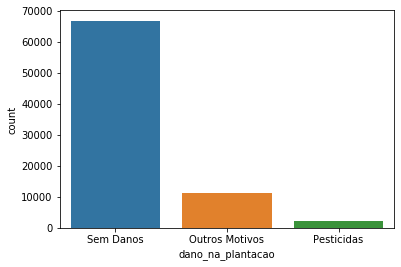

In [9]:
sns.countplot(legends.dano_na_plantacao)

In [10]:
pie = go.Pie(
    labels = legends['dano_na_plantacao'].value_counts().index,
    values = legends['dano_na_plantacao'].value_counts().values,
    )

data = pie
layout = go.Layout(
    title = 'Distribuição de frequência do de danos na plantação',
    )

fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

#### Conclusão dos dados

* Analisando os dados de treino percebe-se que há muito mais agricultores que não tiveram danos nas suas plantações de forma muito distoante. Isso pode prejudicar a predição.

### Estimativa de Insetos

distorção dos dados igual a: 0.837481474862137


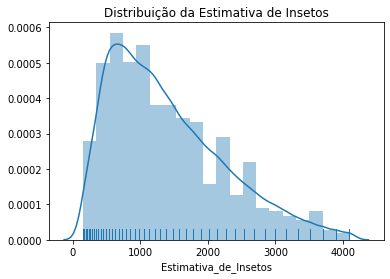

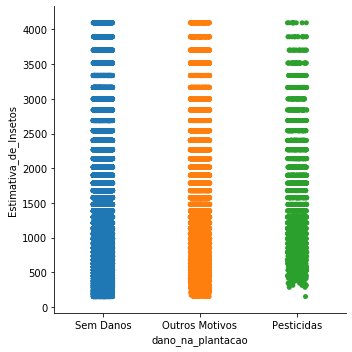

In [11]:
#Plotando gráficos e a skewness dos dados
sns.distplot(legends.Estimativa_de_Insetos, rug=True, bins=20).set_title('Distribuição da Estimativa de Insetos')
sns.catplot(x='dano_na_plantacao', y='Estimativa_de_Insetos', data=legends)
print("distorção dos dados igual a:",legends.Estimativa_de_Insetos.skew())

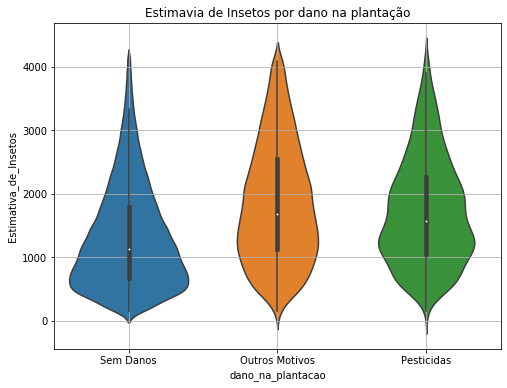

In [12]:
#Plotando um violinplot 
fig, ax = plt.subplots(figsize=(8, 6))

sns.violinplot(x='dano_na_plantacao', y='Estimativa_de_Insetos', data=legends).set_title('Estimavia de Insetos por dano na plantação')
 
plt.grid()

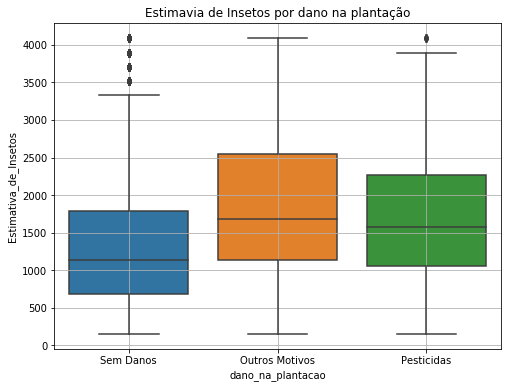

In [13]:
#Plotando um boxplot
fig, ax = plt.subplots(figsize=(8, 6))

sns.boxplot(x='dano_na_plantacao', y='Estimativa_de_Insetos', data=legends).set_title('Estimavia de Insetos por dano na plantação')

plt.grid()

#### Conclusões dos dados

* Quanto menor a estimativa de insetos maiores as chances da plantação não ter dados;
* Estimativas altas de insetos aumentam as chances da plantação sofrer danos por outros motivos;
* O aumento da estimativa de insetos também aumentam as chance da plantanção sofrer dados por conta dos pesticidas;
* O argumento acima pode ser explicado pelo uso excessivo de pesticidas para combater os insetos.

### Tipo de cultivo

Text(0.5, 1.0, 'Quantidade de Tipos de Cultivo')

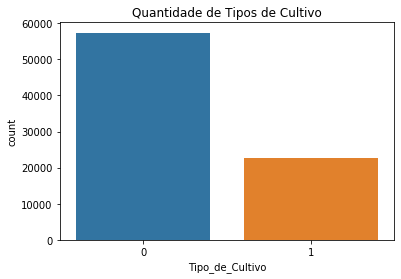

In [14]:
#Plotando gráfico para contar a quantidade de cada variação no Tipo_de_Cultivo
sns.countplot(legends.Tipo_de_Cultivo).set_title('Quantidade de Tipos de Cultivo')

In [15]:
pie = go.Pie(
    labels = legends[legends.dano_na_plantacao == 'Sem Danos']['Tipo_de_Cultivo'].value_counts().index,
    values = legends[legends.dano_na_plantacao == 'Sem Danos']['Tipo_de_Cultivo'].value_counts().values,
    )

data = pie
layout = go.Layout(
    title = 'Distribuição de frequência do Tipo de Cultivo para agricultores sem danos na plantação',
    )

fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

In [16]:
pie = go.Pie(
    labels = legends[legends.dano_na_plantacao == 'Outros Motivos']['Tipo_de_Cultivo'].value_counts().index,
    values = legends[legends.dano_na_plantacao == 'Outros Motivos']['Tipo_de_Cultivo'].value_counts().values,
    )

data = pie
layout = go.Layout(
    title = 'Distribuição de frequência do Tipo de Cultivo para agricultores com danos por outros motivos',
    )

fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

In [17]:
pie = go.Pie(
    labels = legends[legends.dano_na_plantacao == 'Pesticidas']['Tipo_de_Cultivo'].value_counts().index,
    values = legends[legends.dano_na_plantacao == 'Pesticidas']['Tipo_de_Cultivo'].value_counts().values,
    )

data = pie
layout = go.Layout(
    title = 'Distribuição de frequência do Tipo de Cultivo para agricultores com danos por pesticidas',
    )

fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

#### Conclusões dos dados

* Analisando os gráficos plotados é possível concluir que o tipo de cultivo não impacta no dano da plantação

### Tipo de Solo

Text(0.5, 1.0, 'Quantidade de Tipos de Solo')

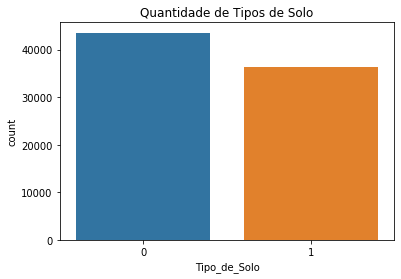

In [18]:
#Plotando gráfico para contar a quantidade de cada variação no Tipo_de_Solo
sns.countplot(legends.Tipo_de_Solo).set_title('Quantidade de Tipos de Solo')

In [19]:
pie = go.Pie(
    labels = legends[legends.dano_na_plantacao == 'Sem Danos']['Tipo_de_Solo'].value_counts().index,
    values = legends[legends.dano_na_plantacao == 'Sem Danos']['Tipo_de_Solo'].value_counts().values,
    )

data = pie
layout = go.Layout(
    title = 'Distribuição de frequência do Tipo de Solo para agricultores sem danos na plantação',
    )

fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

In [20]:
pie = go.Pie(
    labels = legends[legends.dano_na_plantacao == 'Outros Motivos']['Tipo_de_Solo'].value_counts().index,
    values = legends[legends.dano_na_plantacao == 'Outros Motivos']['Tipo_de_Solo'].value_counts().values,
    )

data = pie
layout = go.Layout(
    title = 'Distribuição de frequência do Tipo de Solo para agricultores com danos por outros motivos',
    )

fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

In [21]:
pie = go.Pie(
    labels = legends[legends.dano_na_plantacao == 'Outros Motivos']['Tipo_de_Solo'].value_counts().index,
    values = legends[legends.dano_na_plantacao == 'Outros Motivos']['Tipo_de_Solo'].value_counts().values,
    )

data = pie
layout = go.Layout(
    title = 'Distribuição de frequência do Tipo de Solo para agricultores com danos causados por pesticidas',
    )

fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

#### Conclusão 

* Assim como na variável anterior o tipo de solo não muda muito a distribuição da frequência do tipo de dano na plantação.

### Categoria Pesticida

Text(0.5, 1.0, 'Quantidade de categorias de pesticidas')

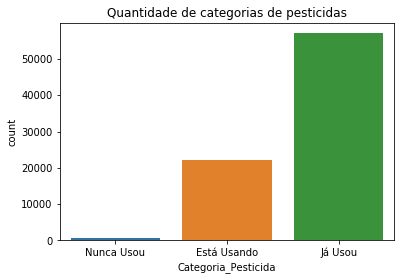

In [22]:
#Plotando gráfico para contar a quantidade de cada variação no Tipo_de_Solo
sns.countplot(legends.Categoria_Pesticida).set_title('Quantidade de categorias de pesticidas')

In [23]:
pie = go.Pie(
    labels = legends[legends.dano_na_plantacao == 'Sem Danos']['Categoria_Pesticida'].value_counts().index,
    values = legends[legends.dano_na_plantacao == 'Sem Danos']['Categoria_Pesticida'].value_counts().values,
    )

data = pie
layout = go.Layout(
    title = 'Distribuição de frequência de uso de pesticidas em plantações sem dano',
    )

fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

In [24]:
pie = go.Pie(
    labels = legends[legends.dano_na_plantacao == 'Outros Motivos']['Categoria_Pesticida'].value_counts().index,
    values = legends[legends.dano_na_plantacao == 'Outros Motivos']['Categoria_Pesticida'].value_counts().values,
    )

data = pie
layout = go.Layout(
    title = 'Distribuição de frequência de uso de pesticidas com danos causados por outros motivos',
    )

fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

In [25]:
pie = go.Pie(
    labels = legends[legends.dano_na_plantacao == 'Pesticidas']['Categoria_Pesticida'].value_counts().index,
    values = legends[legends.dano_na_plantacao == 'Pesticidas']['Categoria_Pesticida'].value_counts().values,
    )

data = pie
layout = go.Layout(
    title = 'Distribuição de frequência de uso de pesticidas com plantações danificadas por pesticidas',
    )

fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

#### Conclusão 

* Os gráficos mostraram alguns dados estranhos. 150 agricultores que nunca usaram pesticidas relatam danos nas suas plantações por conta do uso do produto, são dados sem sentidos no dataset;
* Apesar disso é possível notar que o uso de pesticidas ajuda na proteção da plantação e a grande maioria dos agricultores que já usaram relataram não ter danos nas suas plantações. 

In [26]:
legends.loc[legends.Categoria_Pesticida == 'Nunca Usou']['dano_na_plantacao'].value_counts()

Outros Motivos    509
Pesticidas        150
Sem Danos         104
Name: dano_na_plantacao, dtype: int64

### Doses Semana

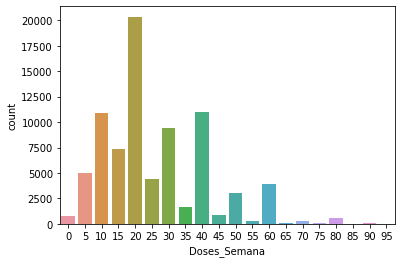

In [27]:
#Plotando gráficos e a skewness dos dados
sns.countplot(x='Doses_Semana', data=legends)

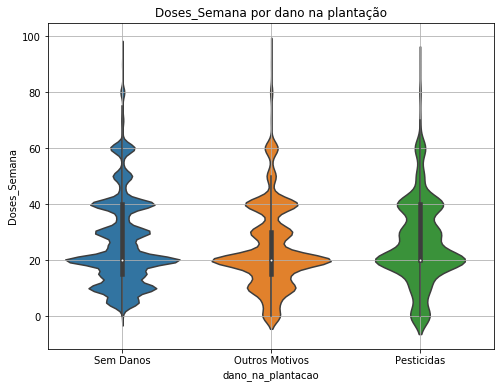

In [28]:
#Plotando um violinplot 
fig, ax = plt.subplots(figsize=(8, 6))

sns.violinplot(x='dano_na_plantacao', y='Doses_Semana', data=legends).set_title('Doses_Semana por dano na plantação')
plt.grid()

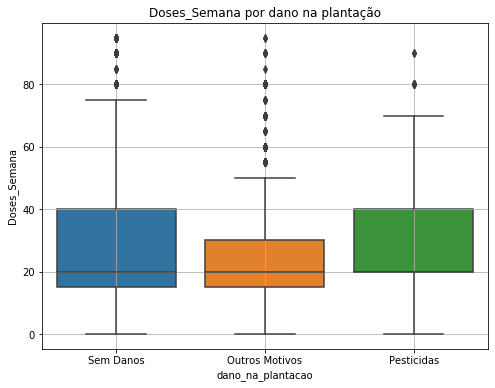

In [29]:
#Plotando um boxplot 
fig, ax = plt.subplots(figsize=(8, 6))

sns.boxplot(x='dano_na_plantacao', y='Doses_Semana', data=legends).set_title('Doses_Semana por dano na plantação')
plt.grid()

In [30]:
pie = go.Pie(
    labels = legends[legends.dano_na_plantacao == 'Sem Danos']['Doses_Semana'].value_counts().index,
    values = legends[legends.dano_na_plantacao == 'Sem Danos']['Doses_Semana'].value_counts().values,
    )

data = pie
layout = go.Layout(
    title = 'Distribuição de frequência de Doses Semanais sem danos na plantação',
    )

fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

In [31]:
pie = go.Pie(
    labels = legends[legends.dano_na_plantacao == 'Outros Motivos']['Doses_Semana'].value_counts().index,
    values = legends[legends.dano_na_plantacao == 'Outros Motivos']['Doses_Semana'].value_counts().values,
    )

data = pie
layout = go.Layout(
    title = 'Distribuição de frequência de Doses Semanais com danos causados por outros motivos',
    )

fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

In [32]:
pie = go.Pie(
    labels = legends[legends.dano_na_plantacao == 'Pesticidas']['Doses_Semana'].value_counts().index,
    values = legends[legends.dano_na_plantacao == 'Pesticidas']['Doses_Semana'].value_counts().values,
    )

data = pie
layout = go.Layout(
    title = 'Distribuição de frequência de Doses Semanais com danos causados por pesticidas',
    )

fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

In [33]:
#Verificando se uma maior dose semanal maior tem relação com danos na plantação
pie = go.Pie(
    labels = legends[legends.dano_na_plantacao == 'Pesticidas']['Doses_Semana'].value_counts().index,
    values = legends[legends.dano_na_plantacao == 'Pesticidas']['Doses_Semana'].value_counts().values,
    )

data = pie
layout = go.Layout(
    title = 'Distribuição de frequência de Doses Semanais com danos causados por pesticidas',
    )

fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

#### Conclusão

* Analisando os gráficos, a maioria dos agricultores do dataset utilizam doses semanais que variam entre 10 à 40 com maior frequência que outras doses;
* Os gráficos expostos não revelam algo muito explícito além da alta frequência das doses semanais citadas acima. Para explorar melhor a possibilidade de altas doses causarem danos seram feitos outros gráficos restringindo o intervalo da variável Doses_Semana

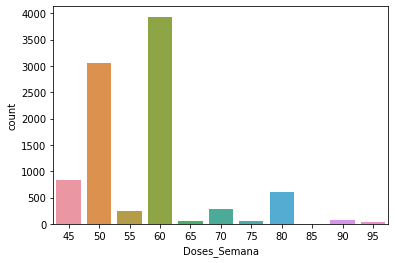

In [34]:
#Plotando gráficos e a skewness dos dados
sns.countplot(x='Doses_Semana', data=legends[legends.Doses_Semana > 40])

In [35]:
#Verificando se uma maior dose semanal maior tem relação com danos na plantação
pie = go.Pie(
    labels = legends[legends.Doses_Semana > 60]['dano_na_plantacao'].value_counts().index,
    values = legends[legends.Doses_Semana > 60]['dano_na_plantacao'].value_counts().values,
    )

data = pie
layout = go.Layout(
    title = 'Distribuição de frequência de Doses Semanais com danos causados por pesticidas',
    )

fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

#### Conclusão

* Até mesmo em casos com altas doses semanais os agricultores não relataram muitos danos na plantação

### Semanas Utilizando

#### Apesar dessa variável ter algumas linhas vazias, iremos montar os gráficos apenas com os valores não nulos

In [36]:
legends_semana = legends.dropna()

distorção dos dados igual a: 0.24440500220070113


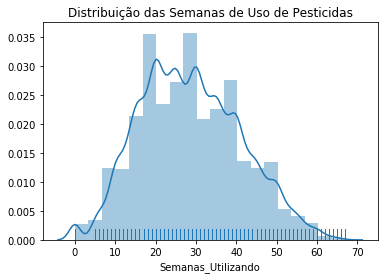

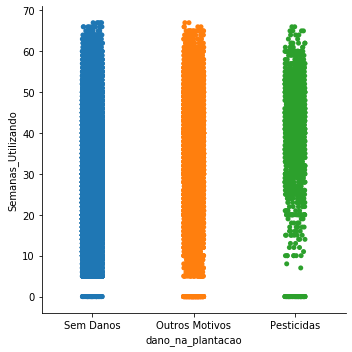

In [37]:
#Plotando gráficos e a skewness dos dados
sns.distplot(legends_semana.Semanas_Utilizando, rug=True, bins=20).set_title('Distribuição das Semanas de Uso de Pesticidas')
sns.catplot(x='dano_na_plantacao', y='Semanas_Utilizando', data=legends_semana)
print("distorção dos dados igual a:",legends_semana.Semanas_Utilizando.skew())

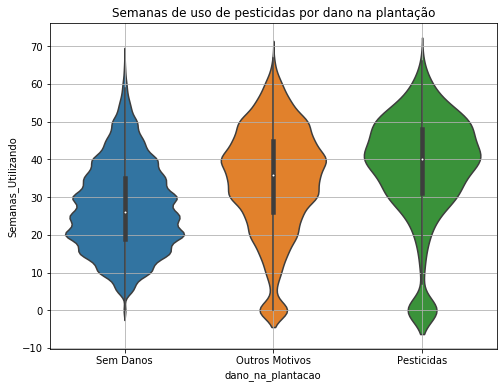

In [38]:
#Plotando um violinplot 
fig, ax = plt.subplots(figsize=(8, 6))

sns.violinplot(x='dano_na_plantacao', y='Semanas_Utilizando', data=legends).set_title('Semanas de uso de pesticidas por dano na plantação')
 
plt.grid()

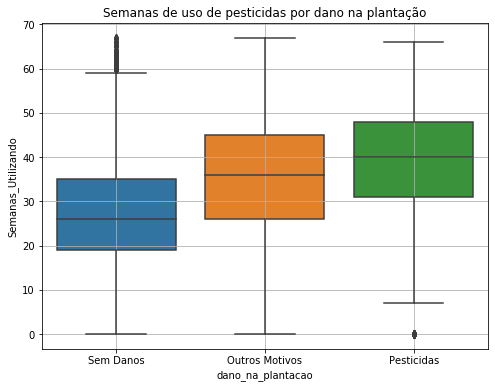

In [39]:
#Plotando um boxplot 
fig, ax = plt.subplots(figsize=(8, 6))

sns.boxplot(x='dano_na_plantacao', y='Semanas_Utilizando', data=legends).set_title('Semanas de uso de pesticidas por dano na plantação')
 
plt.grid()

#### Conclusão

* Analisando a variável atual com a anterior, os gráficos mostram que não apesar da dose semanal não influenciar muito nos dados na plantação, o número excessivo de semanas utilizando um pesticida pode danificar a safra, como mostrado no Violinplot

### Semanas Sem Uso

distorção dos dados igual a: 0.837481474862137


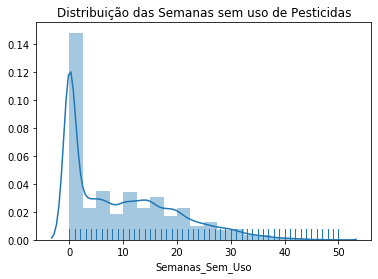

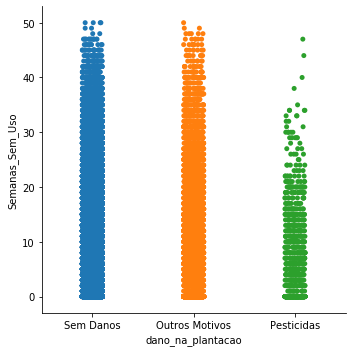

In [40]:
#Plotando gráficos e a skewness dos dados
sns.distplot(legends.Semanas_Sem_Uso, rug=True, bins=20).set_title('Distribuição das Semanas sem uso de Pesticidas')
sns.catplot(x='dano_na_plantacao', y='Semanas_Sem_Uso', data=legends)
print("distorção dos dados igual a:",legends.Estimativa_de_Insetos.skew())

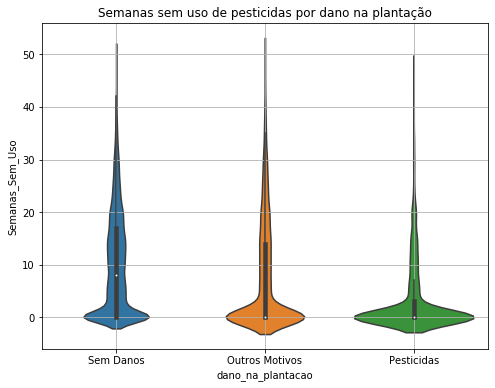

In [41]:
#Plotando um violinplot 
fig, ax = plt.subplots(figsize=(8, 6))

sns.violinplot(x='dano_na_plantacao', y='Semanas_Sem_Uso', data=legends).set_title('Semanas sem uso de pesticidas por dano na plantação')
 
plt.grid()

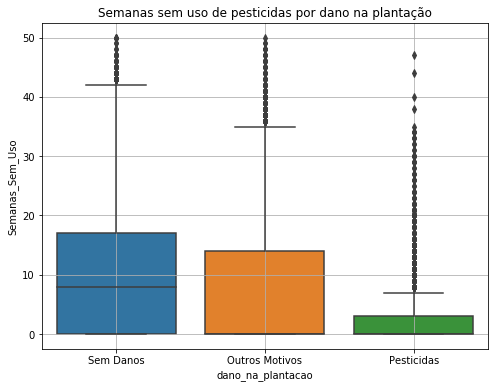

In [42]:
#Plotando um boxplot 
fig, ax = plt.subplots(figsize=(8, 6))

sns.boxplot(x='dano_na_plantacao', y='Semanas_Sem_Uso', data=legends).set_title('Semanas sem uso de pesticidas por dano na plantação')
 
plt.grid()

#### Conclusão 

* A ocorrência de danos causados à plantação por conta de pesticidas está fortemente ligada à uma menor duração de semanas sem a utilização do produto. 

### Temporada

Text(0.5, 1.0, 'Quantidade de Temporadas registradas')

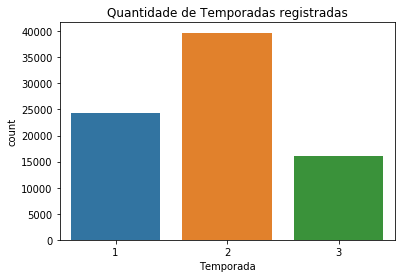

In [43]:
#Plotando gráfico para contar a quantidade de cada variação no Tipo_de_Solo
sns.countplot(legends.Temporada).set_title('Quantidade de Temporadas registradas')

In [44]:
pie = go.Pie(
    labels = legends[legends.dano_na_plantacao == 'Sem Danos']['Temporada'].value_counts().index,
    values = legends[legends.dano_na_plantacao == 'Sem Danos']['Temporada'].value_counts().values,
    )

data = pie
layout = go.Layout(
    title = 'Distribuição de frequência de Temporadas com plantações não danificadas',
    )

fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

In [45]:
pie = go.Pie(
    labels = legends[legends.dano_na_plantacao == 'Outros Motivos']['Temporada'].value_counts().index,
    values = legends[legends.dano_na_plantacao == 'Outros Motivos']['Temporada'].value_counts().values,
    )

data = pie
layout = go.Layout(
    title = 'Distribuição de frequência de Temporadas com plantações danificadas por outros motivos',
    )

fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

In [46]:
pie = go.Pie(
    labels = legends[legends.dano_na_plantacao == 'Pesticidas']['Temporada'].value_counts().index,
    values = legends[legends.dano_na_plantacao == 'Pesticidas']['Temporada'].value_counts().values,
    )

data = pie
layout = go.Layout(
    title = 'Distribuição de frequência de Temporadas com plantações danificadas por pesticidas',
    )

fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

#### Conclusão 

* Nota-se que os gráficos seguem o mesmo padrão de porcentagem nos diferentes tipos de plantações. Isso leva a crer que não muita correlação entre o dano das plantações e a Temporada a qual ela se encontra

### Correlação 

(9.0, 0.0)

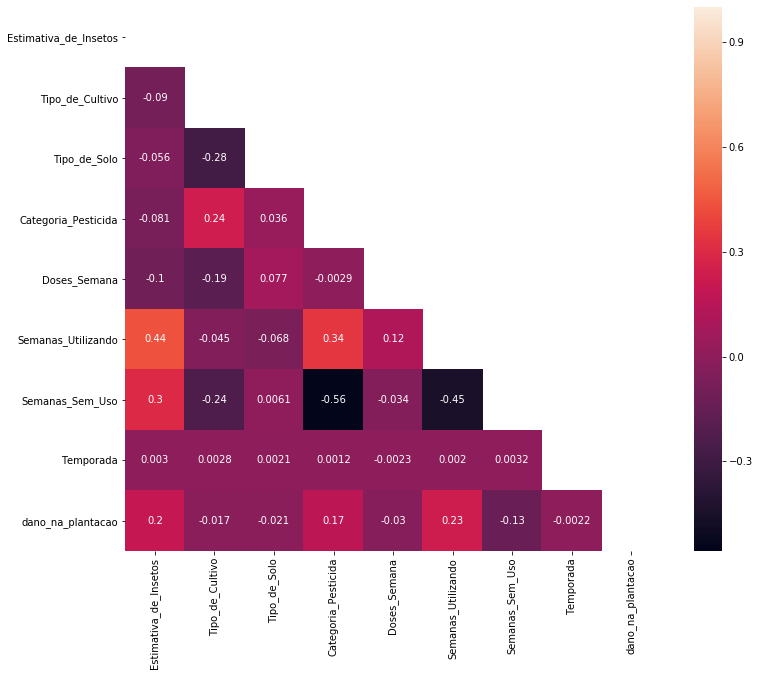

In [47]:
fig, ax = plt.subplots(figsize=(12, 10))

corr = train.iloc[:,1:12].corr()

#Gera uma máscara para a parte superior do heatmap
mask = np.triu(np.ones_like(corr, dtype=np.bool))


ax = sns.heatmap(corr, annot=True, mask=mask)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

## Feature Engineering

#### Outliers

* Analisando os gráficos anteriores é possível destacar os seguintes outliers:
    - Como dito no começo da análise exploratória, os dados de treino possuem muitos casos de agricultores sem danos. Para não prejudicar a predição do modelo os outliers relacionados à agricultores com uma safra sem danos;
    - Estimativa de Insetos superior à 3500 para plantações sem dano e superior à 4000 para danos causados por pesticidas;
    - Doses Semanais maiores que os limites superiores nas variáveis resposta;
    - Semanas de Uso de pesticidas menores que 10 ou 8 para plantações danificados por pesticidas;
    - Plantações com aproximadamente 35 ou mais semanas sem uso de pesticidas danificadas pelo seu uso.

In [214]:
#Vamos fazer uma cópia do dataset de treino e teste para não perder todas as informações originais
train_copy = train.copy()
test_copy = test.copy()

In [215]:
#Dropando linhas que contém outliers para Estimativa_de_Insetos em safras que não tiveram danos
q3, q1 = np.percentile(train_copy[train_copy['dano_na_plantacao'] == 0]['Estimativa_de_Insetos'], [75, 25])

IQR = q3 - q1

limit_inf = q1 - 1.5*IQR
limit_sup = q3 + 1.5*IQR

train_copy = train_copy.loc[~((train_copy['dano_na_plantacao'] == 0) &
                              (train_copy['Estimativa_de_Insetos'] > limit_sup)),:]

In [216]:
#Dropando linhas que contém os outliers para Estimativa_de_Insetos em safras que foram danificadas por pesticidas
q3, q1 = np.percentile(train_copy[train_copy['dano_na_plantacao'] == 2]['Estimativa_de_Insetos'], [75, 25])

IQR = q3 - q1

limit_inf = q1 - 1.5*IQR
limit_sup = q3 + 1.5*IQR

train_copy = train_copy.loc[~((train_copy['dano_na_plantacao'] == 2) &
                              (train_copy['Estimativa_de_Insetos'] > limit_sup)),:]

In [217]:
#Dropando linhas que contém os outliers de Doses Semanais em safras que não foram danificadas
q3, q1 = np.percentile(train_copy[train_copy['dano_na_plantacao'] == 0]['Doses_Semana'], [75, 25])

IQR = q3 - q1

limit_inf = q1 - 1.5*IQR
limit_sup = q3 + 1.5*IQR

train_copy = train_copy.loc[~((train_copy['dano_na_plantacao'] == 2) &
                              (train_copy['Doses_Semana'] > limit_sup)),:]

In [218]:
#Dropando linhas que contém os outliers de Doses Semanais em safras que foram danificadas por pesticidas
q3, q1 = np.percentile(train_copy[train_copy['dano_na_plantacao'] == 2]['Doses_Semana'], [75, 25])

IQR = q3 - q1

limit_inf = q1 - 1.5*IQR
limit_sup = q3 + 1.5*IQR

train_copy = train_copy.loc[~((train_copy['dano_na_plantacao'] == 2) &
                              (train_copy['Doses_Semana'] > limit_sup)),:]

In [219]:
#Analisando o gráfico de pizza de Doses_Semana em plantações danificadas por outros motivos seria melhor retirar Doses > 60 apenas
train_copy = train_copy.loc[~((train_copy['dano_na_plantacao'] == 1) &
                              (train_copy['Doses_Semana'] > 60)),:]

In [220]:
#Para a Semana_Sem_Uso iremos utilizar apenas o limit_sup de dano_na_plantacao 0 
#Além para dano por pesticida, o limite estabelecido será 35
q3, q1 = np.percentile(train_copy[train_copy['dano_na_plantacao'] == 0]['Semanas_Sem_Uso'], [75, 25])

IQR = q3 - q1

limit_inf = q1 - 1.5*IQR
limit_sup = q3 + 1.5*IQR

train_copy = train_copy.loc[~((train_copy['dano_na_plantacao'] == 0) &
                              (train_copy['Semanas_Sem_Uso'] > limit_sup)),:]
train_copy = train_copy.loc[~((train_copy['dano_na_plantacao'] == 1) &
                              (train_copy['Semanas_Sem_Uso'] > limit_sup)),:]
train_copy = train_copy.loc[~((train_copy['dano_na_plantacao'] == 2) &
                              (train_copy['Semanas_Sem_Uso'] > 35)),:]

In [221]:
train_copy.shape

(78424, 11)

#### Outliers Semanas Utilizando

* Para tratar os Outliers da Semanas de Uso é necessário tratar os valores vazios 
* Como a variável Semanas_Utilizando está mais correlacionada com a variável de Estimativas_de_Insetos e Categoria_Pesticida, iremos encher os valores vazios agrupando essas duas colunas, mas para isso é necessário criar uma categoria da Estimativa_de_Insetos. 

In [222]:
#Printando o Range da variável Estimativa_de_Insetos
print(min(train_copy.Estimativa_de_Insetos), max(train_copy.Estimativa_de_Insetos))

150 4097


#### Categorias de Estimativas de Insetos:

* Estimativa_de_Insetos = 0-999: 0
* Estimativa_de_Insetos = 1000-1999: 1
* Estimativa_de_Insetos = 2000-2999: 2
* Estimativa_de_Insetos = 3000-3999: 3
* Estimativa_de_Insetos = 4000-4999: 4

In [223]:
bins = [0, 1000, 2000, 3000, 4000, 5000]
labels = [0,1,2,3,4]
train_copy['Insetos_Group'] = pd.cut(train_copy['Estimativa_de_Insetos'], bins=bins, labels=labels, right=False).astype(int)
test_copy['Insetos_Group'] = pd.cut(test_copy['Estimativa_de_Insetos'], bins=bins, labels=labels, right=False).astype(int)
print(train_copy.Insetos_Group.unique())

[0 1 2 3 4]


In [224]:
train_copy['Semanas_Utilizando'] = train_copy.groupby(['Categoria_Pesticida', 'Insetos_Group'])['Semanas_Utilizando'].transform(
    lambda x: x.fillna(np.mean(x))
)
test_copy['Semanas_Utilizando'] = test_copy.groupby(['Categoria_Pesticida', 'Insetos_Group'])['Semanas_Utilizando'].transform(
    lambda x: x.fillna(np.mean(x))
)

In [225]:
train_copy.isnull().any()

Unnamed: 0                  False
Identificador_Agricultor    False
Estimativa_de_Insetos       False
Tipo_de_Cultivo             False
Tipo_de_Solo                False
Categoria_Pesticida         False
Doses_Semana                False
Semanas_Utilizando          False
Semanas_Sem_Uso             False
Temporada                   False
dano_na_plantacao           False
Insetos_Group               False
dtype: bool

In [226]:
#Agora podemos verificar o limite inferior da variável Semanas_Utilizando em casa de plantações não danificadas
q3, q1 = np.percentile(train_copy.loc[train.dano_na_plantacao == 0]['Semanas_Utilizando'], [75, 25])

IQR = q3 - q1
limit_inf = q1 - 1.5*IQR
limit_sup = q3 + 1.5*IQR

train_copy = train_copy.loc[~((train_copy['dano_na_plantacao'] == 0) &
                              (train_copy['Semanas_Utilizando'] > limit_sup)),:]

In [227]:
#Agora podemos verificar o limite inferior da variável Semanas_Utilizando em casa de plantações danificadas por pesticidas
q3, q1 = np.percentile(train_copy.loc[train.dano_na_plantacao == 0]['Semanas_Utilizando'], [75, 25])

IQR = q3 - q1
limit_inf = q1 - 1.5*IQR
limit_sup = q3 + 1.5*IQR

train_copy = train_copy.loc[~((train_copy['dano_na_plantacao'] == 2) &
                              (train_copy['Semanas_Utilizando'] < limit_inf)),:]

In [325]:
#Separar em X e Y
X = train_copy.drop(['Unnamed: 0', 'Identificador_Agricultor', 'dano_na_plantacao'], axis=True)
y = train_copy.dano_na_plantacao
X_test = test_copy.drop(['Unnamed: 0',  'Identificador_Agricultor'], axis=True)
X.head()

Estimativa_de_Insetos  Tipo_de_Cultivo  Tipo_de_Solo  Categoria_Pesticida  \
0                    188                1             0                    1   
1                    209                1             0                    1   
2                    257                1             0                    1   
3                    257                1             1                    1   
4                    342                1             0                    1   

   Doses_Semana  Semanas_Utilizando  Semanas_Sem_Uso  Temporada  Insetos_Group  
0             0                 0.0                0          1              0  
1             0                 0.0                0          2              0  
2             0                 0.0                0          2              0  
3             0                 0.0                0          2              0  
4             0                 0.0                0          2              0

In [326]:
#Adicionando variáveis que normaliza a curvas de distribuição de Estimativa_de_Insetos
X['Log_Estimativa_de_Insetos'] = np.log1p(X.Estimativa_de_Insetos)
X_test['Log_Estimativa_de_Insetos'] = np.log1p(X_test.Estimativa_de_Insetos)

(10.0, 0.0)

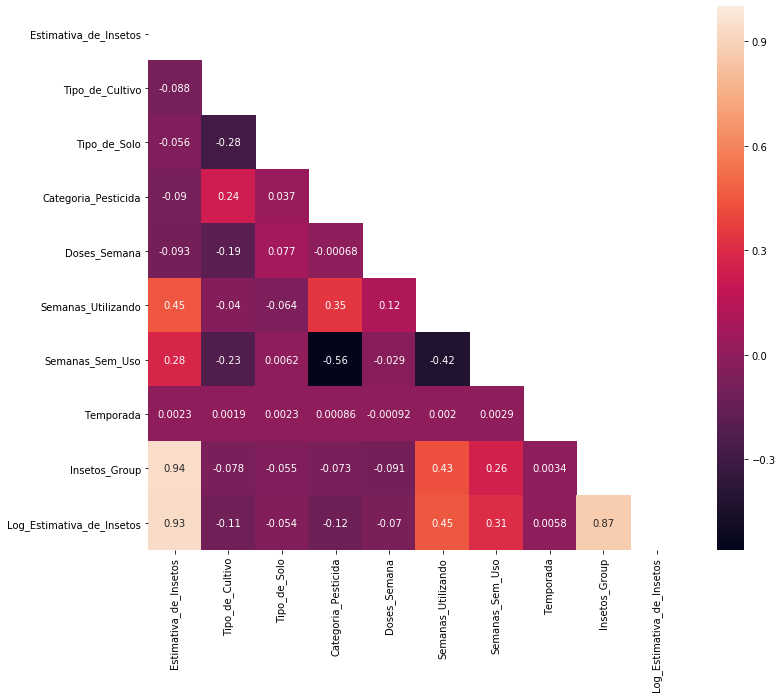

In [327]:
fig, ax = plt.subplots(figsize=(12, 10))

corr = X.corr()

#Gera uma máscara para a parte superior do heatmap
mask = np.triu(np.ones_like(corr, dtype=np.bool))


ax = sns.heatmap(corr, annot=True, mask=mask)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [328]:
#Função para agrupar variáveis que possuam correlação próxima ou maior que 0.3 (sem contar o log)
def feat_eng01(data):
    data['Semanas_Utilizando_vs_Estimativa_de_Insetos'] = data['Semanas_Utilizando']/data['Estimativa_de_Insetos']
    data['Semanas_Utilizando_vs_Categoria_Pesticida'] = data['Semanas_Utilizando']/data['Categoria_Pesticida']
    data['Semanas_Sem_Uso_vs_Estimativa_de_Insetos'] = data['Semanas_Sem_Uso']/data['Estimativa_de_Insetos']
    data['Semanas_Sem_Uso_vs_Categoria_Pesticida'] = data['Semanas_Sem_Uso']/data['Categoria_Pesticida']
    data['Semanas_Utilizando_vs_Semanas_Sem_Uso'] = 0
    for i in data['Semanas_Sem_Uso'].index:
        if data['Semanas_Sem_Uso'][i] == 0:
            data['Semanas_Utilizando_vs_Semanas_Sem_Uso'][i] = 0
        else:
            data['Semanas_Utilizando_vs_Semanas_Sem_Uso'][i] = data['Semanas_Utilizando'][i]/data['Semanas_Sem_Uso'][i]
    return data

In [329]:
X = feat_eng01(X)
X_test = feat_eng01(X_test)

C:\Users\LENOVO\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\LENOVO\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [330]:
X.head()

Estimativa_de_Insetos  Tipo_de_Cultivo  Tipo_de_Solo  Categoria_Pesticida  \
0                    188                1             0                    1   
1                    209                1             0                    1   
2                    257                1             0                    1   
3                    257                1             1                    1   
4                    342                1             0                    1   

   Doses_Semana  Semanas_Utilizando  Semanas_Sem_Uso  Temporada  \
0             0                 0.0                0          1   
1             0                 0.0                0          2   
2             0                 0.0                0          2   
3             0                 0.0                0          2   
4             0                 0.0                0          2   

   Insetos_Group  Log_Estimativa_de_Insetos  \
0              0                   5.241747   
1              0                   5.347108   
2              0                   5.552960   
3              0                   5.552960   
4              0                   5.837730   

   Semanas_Utilizando_vs_Estimativa_de_Insetos  \
0                                          0.0   
1                                          0.0   
2                                          0.0   
3                                          0.0   
4                                          0.0   

   Semanas_Utilizando_vs_Categoria_Pesticida  \
0                                        0.0   
1                                        0.0   
2                                        0.0   
3                                        0.0   
4                                        0.0   

   Semanas_Sem_Uso_vs_Estimativa_de_Insetos  \
0                                       0.0   
1                                       0.0   
2                                       0.0   
3                                       0.0   
4                                       0.0   

   Semanas_Sem_Uso_vs_Categoria_Pesticida  \
0                                     0.0   
1                                     0.0   
2                                     0.0   
3                                     0.0   
4                                     0.0   

   Semanas_Utilizando_vs_Semanas_Sem_Uso  
0                                      0  
1                                      0  
2                                      0  
3                                      0  
4                                      0

In [331]:
X.describe()

Estimativa_de_Insetos  Tipo_de_Cultivo  Tipo_de_Solo  \
count           78126.000000     78126.000000  78126.000000   
mean             1352.430369         0.285424      0.456365   
std               795.142573         0.451619      0.498096   
min               150.000000         0.000000      0.000000   
25%               731.000000         0.000000      0.000000   
50%              1212.000000         0.000000      0.000000   
75%              1898.000000         1.000000      1.000000   
max              4097.000000         1.000000      1.000000   

       Categoria_Pesticida  Doses_Semana  Semanas_Utilizando  Semanas_Sem_Uso  \
count         78126.000000  78126.000000        78126.000000     78126.000000   
mean              2.266825     25.883701           28.427693         9.355503   
std               0.463583     15.467143           11.781075         9.615725   
min               1.000000      0.000000            0.000000         0.000000   
25%               2.000000     15.000000           20.000000         0.000000   
50%               2.000000     20.000000           27.588857         7.000000   
75%               3.000000     40.000000           37.000000        16.000000   
max               3.000000     95.000000           67.000000        40.000000   

          Temporada  Insetos_Group  Log_Estimativa_de_Insetos  \
count  78126.000000   78126.000000               78126.000000   
mean       1.897397       0.844380                   7.015341   
std        0.702048       0.845702                   0.664652   
min        1.000000       0.000000                   5.017280   
25%        1.000000       0.000000                   6.595781   
50%        2.000000       1.000000                   7.100852   
75%        2.000000       1.000000                   7.549083   
max        3.000000       4.000000                   8.318254   

       Semanas_Utilizando_vs_Estimativa_de_Insetos  \
count                                 78126.000000   
mean                                      0.028323   
std                                       0.019725   
min                                       0.000000   
25%                                       0.015736   
50%                                       0.023379   
75%                                       0.035038   
max                                       0.180000   

       Semanas_Utilizando_vs_Categoria_Pesticida  \
count                               78126.000000   
mean                                   12.633613   
std                                     5.110078   
min                                     0.000000   
25%                                     9.000000   
50%                                    12.500000   
75%                                    16.000000   
max                                    32.500000   

       Semanas_Sem_Uso_vs_Estimativa_de_Insetos  \
count                              78126.000000   
mean                                   0.008095   
std                                    0.008724   
min                                    0.000000   
25%                                    0.000000   
50%                                    0.005613   
75%                                    0.013375   
max                                    0.039062   

       Semanas_Sem_Uso_vs_Categoria_Pesticida  \
count                            78126.000000   
mean                                 4.677751   
std                                  4.807862   
min                                  0.000000   
25%                                  0.000000   
50%                                  3.500000   
75%                                  8.000000   
max                                 20.000000   

       Semanas_Utilizando_vs_Semanas_Sem_Uso  
count                           78126.000000  
mean                                3.030720  
std                                 6.707293  
min                                 0.000000  
25%                           

In [332]:
X_test.describe()

Estimativa_de_Insetos  Tipo_de_Cultivo  Tipo_de_Solo  \
count            8858.000000      8858.000000   8858.000000   
mean             1389.902574         0.293746      0.484308   
std               842.295394         0.455503      0.499782   
min               150.000000         0.000000      0.000000   
25%               731.000000         0.000000      0.000000   
50%              1212.000000         0.000000      0.000000   
75%              1898.000000         1.000000      1.000000   
max              4097.000000         1.000000      1.000000   

       Categoria_Pesticida  Doses_Semana  Semanas_Utilizando  Semanas_Sem_Uso  \
count          8858.000000   8858.000000         8858.000000      8858.000000   
mean              2.233461     25.878867           28.247930         9.959359   
std               0.442366     15.529796           11.652907         9.848986   
min               1.000000      0.000000            0.000000         0.000000   
25%               2.000000     15.000000           20.000000         0.000000   
50%               2.000000     20.000000           27.635493         8.000000   
75%               2.000000     40.000000           36.000000        16.000000   
max               3.000000     95.000000           67.000000        50.000000   

         Temporada  Insetos_Group  Log_Estimativa_de_Insetos  \
count  8858.000000    8858.000000                8858.000000   
mean      1.891398       0.884737                   7.035637   
std       0.694461       0.887439                   0.672803   
min       1.000000       0.000000                   5.017280   
25%       1.000000       0.000000                   6.595781   
50%       2.000000       1.000000                   7.100852   
75%       2.000000       1.000000                   7.549083   
max       3.000000       4.000000                   8.318254   

       Semanas_Utilizando_vs_Estimativa_de_Insetos  \
count                                  8858.000000   
mean                                      0.027725   
std                                       0.019365   
min                                       0.000000   
25%                                       0.015338   
50%                                       0.022802   
75%                                       0.034395   
max                                       0.180000   

       Semanas_Utilizando_vs_Categoria_Pesticida  \
count                                8858.000000   
mean                                   12.717393   
std                                     5.091866   
min                                     0.000000   
25%                                     9.000000   
50%                                    12.500000   
75%                                    16.000000   
max                                    31.500000   

       Semanas_Sem_Uso_vs_Estimativa_de_Insetos  \
count                               8858.000000   
mean                                   0.008556   
std                                    0.008811   
min                                    0.000000   
25%                                    0.000000   
50%                                    0.006252   
75%                                    0.014006   
max                                    0.039062   

       Semanas_Sem_Uso_vs_Categoria_Pesticida  \
count                             8858.000000   
mean                                 4.979679   
std                                  4.924493   
min                                  0.000000   
25%                                  0.000000   
50%                                  4.000000   
75%                                  8.000000   
max                                 25.000000   

       Semanas_Utilizando_vs_Semanas_Sem_Uso  
count                            8858.000000  
mean                                3.075073  
std                                 6.720480  
min                                 0.000000  
25%                                 0.0

In [333]:
#Vamos utilizar Standar_Scale nas colunas que não possuem variáveis categóricas, como Tipo_de_Cultivo
X_scale = X.drop(['Tipo_de_Cultivo', 'Tipo_de_Solo', 'Categoria_Pesticida', 'Temporada'], axis=True)
X_test_scale = X_test.drop(['Tipo_de_Cultivo', 'Tipo_de_Solo', 'Categoria_Pesticida', 'Temporada'], axis=True)

#Criar um dataset só com as variáveis categóricas para concatenar com as variáveis que serão redimensionadas
X_Cat = pd.DataFrame(columns=['Tipo_de_Cultivo', 'Tipo_de_Solo', 'Categoria_Pesticida', 'Temporada'], data=X)
X_test_Cat = pd.DataFrame(columns=['Tipo_de_Cultivo', 'Tipo_de_Solo', 'Categoria_Pesticida', 'Temporada'], data=X_test)

In [334]:
X_scale.shape, X_test_scale.shape

((78126, 11), (8858, 11))

In [335]:
sc = StandardScaler()
sc_train = X_scale
sc_test = X_test_scale

In [336]:
sc_train = sc.fit_transform(sc_train)
sc_test = sc.transform(sc_test)

In [337]:
X_scale.iloc[:,0:12] = sc_train[:,0:12]
X_test_scale.iloc[:,0:12] = sc_test[:,0:12]

In [338]:
new_X = pd.concat([X_scale, X_Cat], axis=1, sort=False)
new_X_test = pd.concat([X_test_scale, X_test_Cat], axis=1, sort=False)
X.head()

Estimativa_de_Insetos  Tipo_de_Cultivo  Tipo_de_Solo  Categoria_Pesticida  \
0                    188                1             0                    1   
1                    209                1             0                    1   
2                    257                1             0                    1   
3                    257                1             1                    1   
4                    342                1             0                    1   

   Doses_Semana  Semanas_Utilizando  Semanas_Sem_Uso  Temporada  \
0             0                 0.0                0          1   
1             0                 0.0                0          2   
2             0                 0.0                0          2   
3             0                 0.0                0          2   
4             0                 0.0                0          2   

   Insetos_Group  Log_Estimativa_de_Insetos  \
0              0                   5.241747   
1              0                   5.347108   
2              0                   5.552960   
3              0                   5.552960   
4              0                   5.837730   

   Semanas_Utilizando_vs_Estimativa_de_Insetos  \
0                                          0.0   
1                                          0.0   
2                                          0.0   
3                                          0.0   
4                                          0.0   

   Semanas_Utilizando_vs_Categoria_Pesticida  \
0                                        0.0   
1                                        0.0   
2                                        0.0   
3                                        0.0   
4                                        0.0   

   Semanas_Sem_Uso_vs_Estimativa_de_Insetos  \
0                                       0.0   
1                                       0.0   
2                                       0.0   
3                                       0.0   
4                                       0.0   

   Semanas_Sem_Uso_vs_Categoria_Pesticida  \
0                                     0.0   
1                                     0.0   
2                                     0.0   
3                                     0.0   
4                                     0.0   

   Semanas_Utilizando_vs_Semanas_Sem_Uso  
0                                      0  
1                                      0  
2                                      0  
3                                      0  
4                                      0

## Training and Modeling 

In [367]:
X_train, X_valid, y_train, y_valid = train_test_split(new_X, y, test_size=0.2)

### RandomForest

In [368]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier()

In [369]:
clf_valid = clf.predict(X_valid)
print(accuracy_score(y_valid, clf_valid).round(3))

0.833


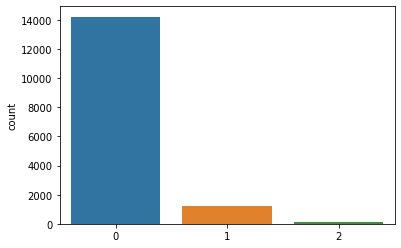

In [370]:
sns.countplot(clf_valid)

### Hyperparâmetros

In [380]:
# Create the parameter grid based on the results of random search 
param_distributions = {
    'bootstrap': [True],
    'max_depth': [34, 37, 40],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [50, 100, 150]
}
clf = RandomForestClassifier()
# Instantiate the grid search model
random_search = RandomizedSearchCV(estimator = clf, param_distributions = param_distributions, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [381]:
random_search.fit(X_train, y_train)
best = random_search.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.0min finished


In [384]:
clf = RandomForestClassifier(**best)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=34, max_features=3, min_samples_leaf=4,
                       min_samples_split=12, n_estimators=150)

In [386]:
clf_valid = clf.predict(X_valid)
accuracy_score(y_valid, clf_valid).round(3)


0.854

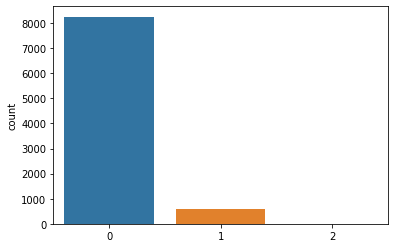

In [387]:
clf_pred = clf.predict(new_X_test)
sns.countplot(clf_pred)

In [394]:
test['dano_na_plantacao'] = clf_pred
test.to_csv('Safra_2020_resp.csv', index=False)